# Crypto Market Prediction: Modeling & Backtesting Notebook  
This notebook implements the full modeling pipeline for predicting next-day cryptocurrency market behavior (BTC and ETH).  
It integrates technical indicators, volume dynamics, time-based features, and news sentiment to build classification and regression models, followed by a simple backtest.

---

## Notebook Structure

### **1. Data Preparation & Feature Engineering**
- Load merged datasets containing price, technical indicators, and sentiment features  
- Standardize column names for consistent modeling  
- Create additional engineered features:
  - Price momentum features (returns, SMA, EMA)
  - Volume-based features (volume z-score, volume change)
  - Time features (day_of_week, weekend)
  - Target labels (`direction_label`, `vol_label`)

---

### **2. Model Targets**
- **Direction Prediction (classification):**  
  `direction_label = 1` if next day's close > today’s close, else `0`.
  
- **Volatility Prediction (regression):**  
  `vol_label = |close_tmr - close|`

These targets support both classification and regression modeling.

---

### **3. Train / Validation / Test Split**
- Time-based chronological split (70% / 15% / 15%)  
- Prevents data leakage by ensuring no future information is used for training

---

### **4. Models Implemented**
#### **Baseline Model**
- Logistic Regression (classification)

#### **Main Models**
- XGBoost Classifier → predict market direction (up/down)  
- XGBoost Regressor → predict next-day volatility

Each model is evaluated using:
- **Classification metrics:** Accuracy, F1-score, ROC-AUC  
- **Regression metrics:** MAE, RMSE  

---

### **5. Backtesting Framework**
- Convert predicted direction into trading positions (long/short)
- Compute strategy returns using next-day price changes  
- Compare strategy performance to Buy-and-Hold benchmark  
- Plot cumulative returns for BTC and ETH

---

## Goal of This Notebook
To build, evaluate, and interpret predictive models for cryptocurrency market movements using a combination of numerical and sentiment-based features, and to test whether model-generated signals can outperform a simple buy-and-hold strategy.

---


## 1. Load BTC/ETH price features & daily sentiment features

We merge:
- Technical indicators (SMA, RSI, MACD, volatility…)
- News-based features (DailySentimentMean, PositiveRatio, NewsCount, SentimentZScore)
- Raw price data

Goal:
Prepare a single clean DataFrame for modeling.


In [1]:
import pandas as pd
import numpy as np

btc = pd.read_csv("data\BTC_features.csv", parse_dates=["date"])
eth = pd.read_csv("data\ETH_features.csv", parse_dates=["date"])
daily_sent = pd.read_csv("data\daily_sentiment_features.csv", parse_dates=["date"])

btc_train = btc.merge(daily_sent, on="date", how="left")
eth_train = eth.merge(daily_sent, on="date", how="left")

btc_train.head()

,open,high,low,close,volume,adjusted,date,day_of_week,weekend,daily_return,...,volatility_21d,volume_zscore,volume_change,day_of_week_num,DailySentimentMean,DailySentimentMedian,PositiveRatio,NegativeRatio,NewsCount,SentimentZScore
0,98496.42969,99655.50000,97222.66406,98997.66406,7.847358e+10,98997.66406,2024-11-22,Friday,0,0.005004,...,0.033622,0.173963,-0.259858,4,0.085320,0.0000,0.400000,0.100000,10.0,-0.258922
1,99006.74219,99014.67969,97232.89063,97777.28125,4.441464e+10,97777.28125,2024-11-23,Saturday,1,-0.012327,...,0.033972,-0.942472,-0.434018,5,0.020225,0.0000,0.250000,0.250000,4.0,-0.651242
2,97778.09375,98647.17969,95788.07813,98013.82031,5.171202e+10,98013.82031,2024-11-24,Sunday,1,0.002419,...,0.033666,-0.755736,0.164301,6,0.058533,0.0000,0.333333,0.333333,3.0,-0.420362
3,98033.44531,98935.03125,92642.91406,93102.29688,8.090946e+10,93102.29688,2024-11-25,Monday,0,-0.050111,...,0.036206,0.143731,0.564616,0,0.371638,0.3119,0.625000,0.000000,8.0,1.466682
4,93087.28125,94991.75000,90770.81250,91985.32031,9.165652e+10,91985.32031,2024-11-26,Tuesday,0,-0.011997,...,0.036663,0.444454,0.132828,1,0.088889,0.0000,0.222222,0.000000,9.0,-0.237413


## 2. Create prediction targets (labels)

We generate two targets:
### (a) Direction Prediction (Classification)
- `direction_label = 1` if tomorrow's close > today's close  
- `direction_label = 0` otherwise  

### (b) Volatility Prediction (Regression)
- `vol_label`: absolute return (|next_close - close|)

This matches the evaluation plan:
- Logistic Regression / XGBoost → classification
- XGBoostRegressor → volatility regression


In [2]:
def create_labels(df):
  
    df = df.sort_values("date").copy()
    
    # Tomorrow's close based on the specified close column
    df["close_tmr"] = df['close'].shift(-1)
    
    # Binary direction label: 1 = up, 0 = down or flat
    df["direction_label"] = (df["close_tmr"] > df['close']).astype(int)
    
    # Volatility label: absolute 1-day price change
    df["vol_label"] = (df["close_tmr"] - df['close']).abs()
    
    return df

# Apply to BTC and ETH with their specific column names
btc_train = create_labels(btc_train)
eth_train = create_labels(eth_train)

btc_train

,open,high,low,close,volume,adjusted,date,day_of_week,weekend,daily_return,...,day_of_week_num,DailySentimentMean,DailySentimentMedian,PositiveRatio,NegativeRatio,NewsCount,SentimentZScore,close_tmr,direction_label,vol_label
0,98496.42969,99655.50000,97222.66406,98997.66406,7.847358e+10,98997.66406,2024-11-22,Friday,0,0.005004,...,4,0.085320,0.00000,0.400000,0.100000,10.0,-0.258922,97777.28125,0,1220.38281
1,99006.74219,99014.67969,97232.89063,97777.28125,4.441464e+10,97777.28125,2024-11-23,Saturday,1,-0.012327,...,5,0.020225,0.00000,0.250000,0.250000,4.0,-0.651242,98013.82031,1,236.53906
2,97778.09375,98647.17969,95788.07813,98013.82031,5.171202e+10,98013.82031,2024-11-24,Sunday,1,0.002419,...,6,0.058533,0.00000,0.333333,0.333333,3.0,-0.420362,93102.29688,0,4911.52343
3,98033.44531,98935.03125,92642.91406,93102.29688,8.090946e+10,93102.29688,2024-11-25,Monday,0,-0.050111,...,0,0.371638,0.31190,0.625000,0.000000,8.0,1.466682,91985.32031,0,1116.97657
4,93087.28125,94991.75000,90770.81250,91985.32031,9.165652e+10,91985.32031,2024-11-26,Tuesday,0,-0.011997,...,1,0.088889,0.00000,0.222222,0.000000,9.0,-0.237413,95962.53125,1,3977.21094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,114129.08590,116078.98440,112291.67970,112956.16410,6.452807e+10,112956.16410,2025-10-28,Tuesday,0,-0.010193,...,1,0.198300,0.05135,0.500000,0.000000,8.0,0.421996,110055.30470,0,2900.85940
341,112921.32810,113642.72660,109368.71880,110055.30470,6.219204e+10,110055.30470,2025-10-29,Wednesday,0,-0.025681,...,2,0.003438,0.00000,0.250000,0.250000,8.0,-0.752419,108305.54690,0,1749.75780
342,110059.19530,111612.35160,106376.68750,108305.54690,6.967396e+10,108305.54690,2025-10-30,Thursday,0,-0.015899,...,3,-0.170750,-0.14055,0.000000,0.750000,4.0,-1.802228,109556.16410,1,1250.61720
343,108304.41410,111031.82030,108288.27340,109556.16410,6.009036e+10,109556.16410,2025-10-31,Friday,0,0.011547,...,4,0.111957,0.00000,0.285714,0.000000,7.0,-0.098383,110064.01560,1,507.85150


## 3. Define feature columns for modeling

We select:
- Price & return features
- Technical indicators
- Volume features
- Time features
- Sentiment features

We explicitly exclude:
- `date` (used for sorting and merging)
- `day_of_week` (string)
- target columns: `close_tmr`, `direction_label`, `vol_label`


In [3]:
# Sentiment features
sent_cols = [
    "DailySentimentMean",
    "DailySentimentMedian",
    "PositiveRatio",
    "NegativeRatio",
    "NewsCount",
    "SentimentZScore",
]

# Price & return features
price_cols = [
    "open",
    "high",
    "low",
    "close",
    "volume",
    "daily_return",
    "log_return",
]

# Technical & volatility features
tech_cols = [
    "SMA_5",
    "SMA_10",
    "SMA_20",
    "EMA_12",
    "RSI_14",
    "MACD_line",
    "MACD_signal",
    "MACD_hist",
    "volatility_7d",
    "volatility_21d",
    "volume_zscore",
    "volume_change",
]

# Time features (numeric)
time_cols = [
    "weekend",
    "day_of_week_num",
]

# Final feature list (shared by BTC and ETH)
feature_cols = sent_cols + price_cols + tech_cols + time_cols

print("Number of features:", len(feature_cols))
feature_cols


Number of features: 27


['DailySentimentMean',
 'DailySentimentMedian',
 'PositiveRatio',
 'NegativeRatio',
 'NewsCount',
 'SentimentZScore',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'daily_return',
 'log_return',
 'SMA_5',
 'SMA_10',
 'SMA_20',
 'EMA_12',
 'RSI_14',
 'MACD_line',
 'MACD_signal',
 'MACD_hist',
 'volatility_7d',
 'volatility_21d',
 'volume_zscore',
 'volume_change',
 'weekend',
 'day_of_week_num']

## 4. Time-based split (train / validation / test)

Important:

To avoid **data leakage**, we do NOT shuffle data.
We use a chronological split:

- Train: 70%
- Validation: 15%
- Test: 15%

In [4]:
def time_split(df, feature_cols):
    """
    Split a time-series DataFrame into train / validation / test subsets.

    - Drops rows with missing features or missing direction_label
    - Sorts by date
    - Uses 70% / 15% / 15% chronological split
    """
    # Drop rows with missing features or labels
    df = df.dropna(subset=feature_cols + ["direction_label"]).copy()
    df = df.sort_values("date")

    n = len(df)
    train_end = int(n * 0.70)
    val_end = int(n * 0.85)

    train = df.iloc[:train_end]
    val   = df.iloc[train_end:val_end]
    test  = df.iloc[val_end:]

    return train, val, test

# Apply to BTC&ETH 
btc_tr, btc_val, btc_test = time_split(btc_train, feature_cols)
btc_tr.shape, btc_val.shape, btc_test.shape

eth_tr, eth_val, eth_test = time_split(eth_train, feature_cols)
eth_tr.shape, eth_val.shape, eth_test.shape


((224, 33), (48, 33), (48, 33))

## 5. Baseline model: Logistic Regression 

Goal:
- Based on today’s information, is the price more likely to go up or down tomorrow?

Task:
- Predict `direction_label` (1 = next day up, 0 = down/flat)

Purpose:
- Serves as a baseline to compare with more advanced models
- Shows whether a simple linear model can detect meaningful patterns

Metrics:
- Accuracy
- F1-score
- ROC-AUC


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Prepare BTC train/validation sets
X_train_btc = btc_tr[feature_cols]
y_train_btc = btc_tr["direction_label"]

X_val_btc = btc_val[feature_cols]
y_val_btc = btc_val["direction_label"]

# Initialize and train Logistic Regression
lr_btc = LogisticRegression(max_iter=1000)
lr_btc.fit(X_train_btc, y_train_btc)

# Predictions on validation set
pred_val_btc = lr_btc.predict(X_val_btc)
proba_val_btc = lr_btc.predict_proba(X_val_btc)[:, 1]

# Evaluation metrics
print("BTC - Logistic Regression")
print("Accuracy:", accuracy_score(y_val_btc, pred_val_btc))
print("F1-score:", f1_score(y_val_btc, pred_val_btc))
print("ROC-AUC:", roc_auc_score(y_val_btc, proba_val_btc))


BTC - Logistic Regression
Accuracy: 0.4375
F1-score: 0.6086956521739131
ROC-AUC: 0.4409171075837743


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Prepare ETH train/validation sets
X_train_eth = eth_tr[feature_cols]
y_train_eth = eth_tr["direction_label"]

X_val_eth = eth_val[feature_cols]
y_val_eth = eth_val["direction_label"]

# Initialize and train Logistic Regression
lr_eth = LogisticRegression(max_iter=1000)
lr_eth.fit(X_train_eth, y_train_eth)

# Predictions on validation set
pred_val_eth = lr_eth.predict(X_val_eth)
proba_val_eth = lr_eth.predict_proba(X_val_eth)[:, 1]

# Evaluation metrics
print("ETH - Logistic Regression")
print("Accuracy:", accuracy_score(y_val_eth, pred_val_eth))
print("F1-score:", f1_score(y_val_eth, pred_val_eth))
print("ROC-AUC:", roc_auc_score(y_val_eth, proba_val_eth))


ETH - Logistic Regression
Accuracy: 0.6041666666666666
F1-score: 0.7397260273972602
ROC-AUC: 0.656084656084656


| Model               | Asset | ROC-AUC   | Flip AUC  | Notes           |
| ------------------- | ----- | --------- | --------- | --------------- |
| Logistic Regression | BTC   | 0.441     | **0.559** | Inverted signal |
| Logistic Regression | ETH   | **0.656** | –         | Direct signal   |


## 6. Main model: XGBoost 

model:
- What is the probability that the price will go up tomorrow?

Unlike logistic regression, XGBoost can learn non-linear relationships and feature interactions such as:

“Low RSI + negative sentiment → likely to drop”

“High volume + positive sentiment → strong uptrend”


We train an XGBoost classifier to predict `direction_label`.


Metrics:
- Accuracy
- F1
- ROC-AUC


In [7]:
from xgboost import XGBClassifier

# XGBoost classifier for BTC
xgb_clf_btc = XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
)

xgb_clf_btc.fit(X_train_btc, y_train_btc)

# Validation predictions
pred_val_btc_xgb = xgb_clf_btc.predict(X_val_btc)
proba_val_btc_xgb = xgb_clf_btc.predict_proba(X_val_btc)[:, 1]

print("BTC - XGBoost Classifier")
print("Accuracy:", accuracy_score(y_val_btc, pred_val_btc_xgb))
print("F1-score:", f1_score(y_val_btc, pred_val_btc_xgb))
print("ROC-AUC:", roc_auc_score(y_val_btc, proba_val_btc_xgb))


BTC - XGBoost Classifier
Accuracy: 0.4166666666666667
F1-score: 0.391304347826087
ROC-AUC: 0.3738977072310406


In [8]:
from xgboost import XGBClassifier

# XGBoost classifier for ETH
xgb_clf_eth = XGBClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
)

xgb_clf_eth.fit(X_train_eth, y_train_eth)

# Validation predictions
pred_val_eth_xgb = xgb_clf_eth.predict(X_val_eth)
proba_val_eth_xgb = xgb_clf_eth.predict_proba(X_val_eth)[:, 1]

print("ETH - XGBoost Classifier")
print("Accuracy:", accuracy_score(y_val_eth, pred_val_eth_xgb))
print("F1-score:", f1_score(y_val_eth, pred_val_eth_xgb))
print("ROC-AUC:", roc_auc_score(y_val_eth, proba_val_eth_xgb))


ETH - XGBoost Classifier
Accuracy: 0.5416666666666666
F1-score: 0.5
ROC-AUC: 0.6014109347442681


| Metric              | BTC | ETH |
|---------------------|-----|-----|
| Accuracy            | 0.4167 | 0.5417 |
| F1-score            | 0.3913 | 0.5000 |
| ROC-AUC             | 0.3739 | 0.6014 |
| Flip AUC (1 − AUC)  | **0.6261** | – |

#### 6-2. Confusion Matrix Analysis

Accuracy and ROC-AUC alone do not fully explain model behavior in highly volatile and imbalanced markets such as cryptocurrencies.  
Therefore, we further analyze the classification results using **confusion matrices**, which provide a detailed breakdown of prediction outcomes.

A confusion matrix decomposes predictions into four categories:

- **True Positive (TP):** correctly predicted upward movement  
- **False Negative (FN):** actual upward movement predicted as downward  
- **False Positive (FP):** actual downward movement predicted as upward  
- **True Negative (TN):** correctly predicted downward movement  

This analysis is particularly important because crypto markets often exhibit **class imbalance** (e.g., more down days than up days), making accuracy potentially misleading.


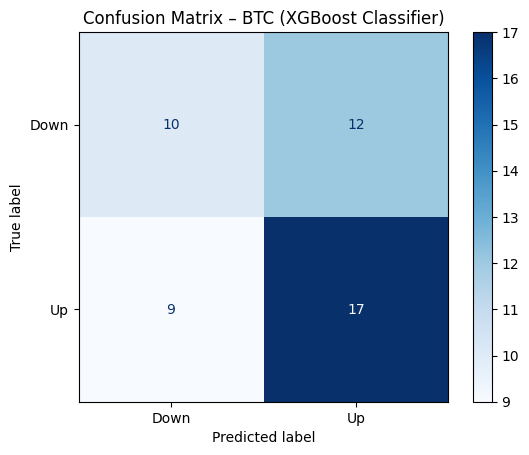

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# BTC true label and predicted label (from btc_test)
y_true_btc = btc_test["direction_label"]
X_btc_test = btc_test[feature_cols]
y_pred_btc = xgb_clf_btc.predict(X_btc_test)

cm_btc = confusion_matrix(y_true_btc, y_pred_btc)

disp_btc = ConfusionMatrixDisplay(
    confusion_matrix=cm_btc,
    display_labels=["Down", "Up"]
)
disp_btc.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – BTC (XGBoost Classifier)")
plt.show()


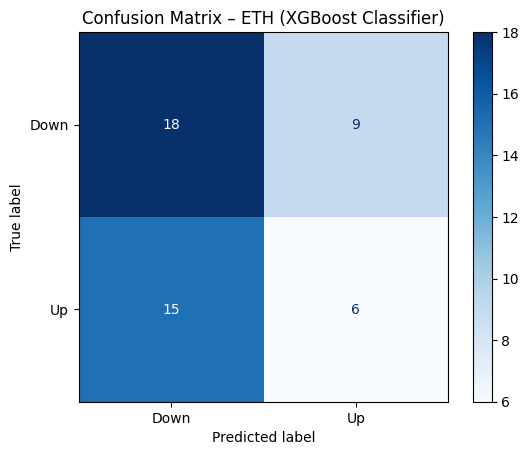

In [12]:
# ETH true label and predicted label (from eth_test)
y_true_eth = eth_test["direction_label"]
X_eth_test = eth_test[feature_cols]
y_pred_eth = xgb_clf_eth.predict(X_eth_test)

cm_eth = confusion_matrix(y_true_eth, y_pred_eth)

disp_eth = ConfusionMatrixDisplay(
    confusion_matrix=cm_eth,
    display_labels=["Down", "Up"]
)
disp_eth.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix – ETH (XGBoost Classifier)")
plt.show()


### 6.3 Discussion: Confusion Matrix and Flip AUC

The confusion matrix results indicate that misclassifications are **not purely random**, but instead follow a consistent pattern.

For BTC, the confusion matrix combined with a ROC-AUC below 0.5 suggests an **inverted relationship** between the model’s predictions and actual outcomes.  
This justifies the use of **Flip AUC (1 − AUC)** as an effective measure of predictive structure rather than treating the model as uninformative.

Importantly, this inverted signal is directly exploited in the trading strategy by reversing the position direction, which leads to strong out-of-sample performance and consistent outperformance relative to Buy & Hold.


## 7. Predict next-day volatility using XGBoostRegressor

Model:
- How large will tomorrow’s price movement be?

The output is a continuous value representing expected volatility or absolute return, such as:

0.003 → ~0.3% expected move

0.02 → ~2% move

0.05 → ~5% move

Purpose:

Determines how large the position should be
→ position sizing (portfolio weights)

Task:
- Predict `vol_label` = absolute 1-day price change

Metrics:
- MAE (Mean Absolute Error)
- RMSE (Root Mean Squared Error)


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare regression targets
y_train_btc_vol = btc_tr["vol_label"]
y_val_btc_vol = btc_val["vol_label"]

xgb_reg_btc = XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_reg_btc.fit(X_train_btc, y_train_btc_vol)

pred_val_btc_vol = xgb_reg_btc.predict(X_val_btc)



mse = mean_squared_error(y_val_btc_vol, pred_val_btc_vol)  # this is MSE
rmse = mse ** 0.5  # or np.sqrt(mse)
print("BTC - XGBoost Regressor (Volatility)")
print("MAE:", mean_absolute_error(y_val_btc_vol, pred_val_btc_vol))
print("RMSE:", rmse)



BTC - XGBoost Regressor (Volatility)
MAE: 1196.3833021982834
RMSE: 1442.7856296415885


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prepare regression targets for ETH
y_train_eth_vol = eth_tr["vol_label"]
y_val_eth_vol = eth_val["vol_label"]

xgb_reg_eth = XGBRegressor(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

xgb_reg_eth.fit(X_train_eth, y_train_eth_vol)

pred_val_eth_vol = xgb_reg_eth.predict(X_val_eth)

print("ETH - XGBoost Regressor (Volatility)")

mse = mean_squared_error(y_val_eth_vol, pred_val_eth_vol)  # this is MSE
rmse = mse ** 0.5  # or np.sqrt(mse)

print("MAE:", mean_absolute_error(y_val_eth_vol, pred_val_eth_vol))
print("RMSE:", rmse)



ETH - XGBoost Regressor (Volatility)
MAE: 115.52126622200053
RMSE: 143.6123407905763


## 8. Simple backtest: BTC/ETH directional strategy

Strategy:
- Use XGBoost classifier predictions on the **test set**
- If predicted label = 1 → go long 1 unit for the next day
- If predicted label = 0 → go short 1 unit for the next day

We compare:
- Strategy cumulative return
- Buy-and-hold cumulative return


In [ ]:
# Prepare BTC test set
X_test_btc = btc_test[feature_cols]
y_test_btc = btc_test["direction_label"]

# Use XGBoost classifier for signals
btc_test = btc_test.copy()
btc_test["pred_label"] = xgb_clf_btc.predict(X_test_btc)

# Next-day return based on close and close_tmr
btc_test["return_next"] = btc_test["close_tmr"] / btc_test["close"] - 1

# Strategy return: long if pred_label=1, short if pred_label=0
btc_test["position"] = btc_test["pred_label"].replace({0: -1, 1: 1})
btc_test["strategy_ret"] = btc_test["position"] * btc_test["return_next"]

# Cumulative returns
btc_test["cum_strategy"] = (1 + btc_test["strategy_ret"]).cumprod()
btc_test["cum_buyhold"] = (1 + btc_test["return_next"]).cumprod()

btc_test[["date", "cum_strategy", "cum_buyhold"]].tail()


,date,cum_strategy,cum_buyhold
339,2025-10-27,1.186666,0.978758
340,2025-10-28,1.156191,0.953622
341,2025-10-29,1.174573,0.938461
342,2025-10-30,1.161010,0.949297
343,2025-10-31,1.155628,0.953698


In [ ]:
# Prepare ETH test set
X_test_eth = eth_test[feature_cols]
y_test_eth = eth_test["direction_label"]

eth_test = eth_test.copy()
eth_test["pred_label"] = xgb_clf_eth.predict(X_test_eth)

# Next-day return for ETH
eth_test["return_next"] = eth_test["close_tmr"] / eth_test["close"] - 1

# Strategy: long if pred_label=1, short if pred_label=0
eth_test["position"] = eth_test["pred_label"].replace({0: -1, 1: 1})
eth_test["strategy_ret"] = eth_test["position"] * eth_test["return_next"]

# Cumulative returns for ETH
eth_test["cum_strategy"] = (1 + eth_test["strategy_ret"]).cumprod()
eth_test["cum_buyhold"] = (1 + eth_test["return_next"]).cumprod()

eth_test[["date", "cum_strategy", "cum_buyhold"]].tail()


,date,cum_strategy,cum_buyhold
339,2025-10-27,1.138503,0.863907
340,2025-10-28,1.161063,0.846788
341,2025-10-29,1.190504,0.825316
342,2025-10-30,1.203868,0.834581
343,2025-10-31,1.195385,0.840461


## 8.1 Plot BTC strategy vs. buy-and-hold


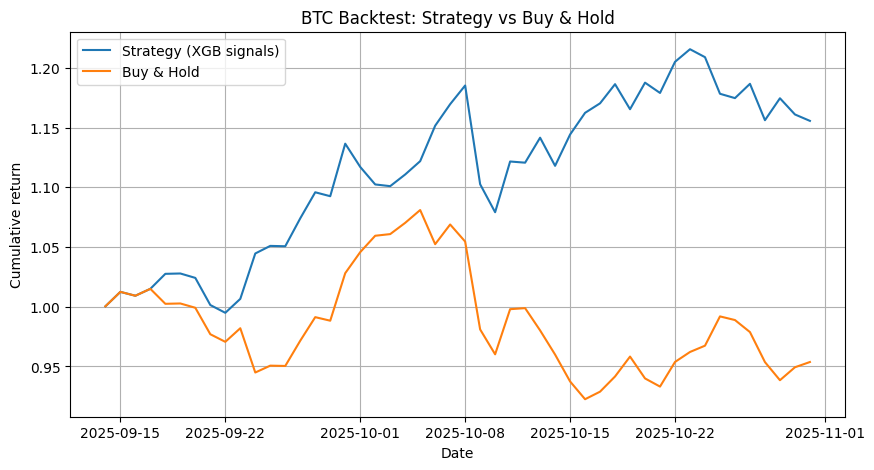

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(btc_test["date"], btc_test["cum_strategy"], label="Strategy (XGB signals)")
plt.plot(btc_test["date"], btc_test["cum_buyhold"], label="Buy & Hold")
plt.legend()
plt.title("BTC Backtest: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.grid(True)
plt.show()


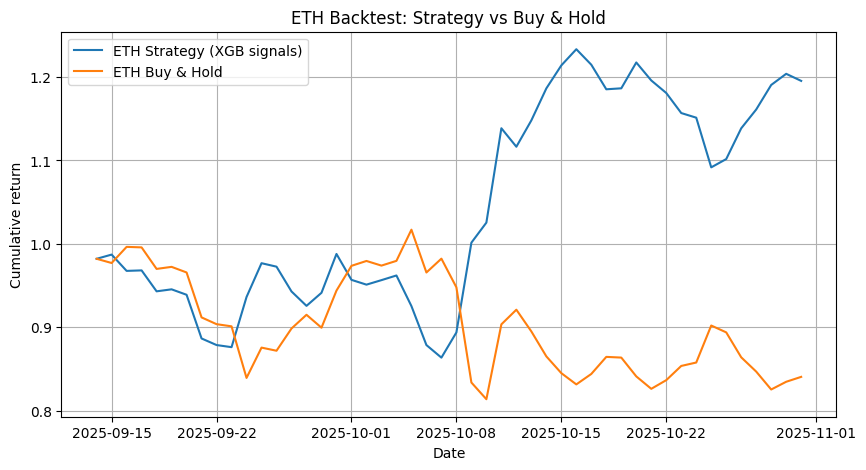

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(eth_test["date"], eth_test["cum_strategy"], label="ETH Strategy (XGB signals)")
plt.plot(eth_test["date"], eth_test["cum_buyhold"], label="ETH Buy & Hold")
plt.legend()
plt.title("ETH Backtest: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Cumulative return")
plt.grid(True)
plt.show()

## explaination

### BTC: XGB Strategy vs Buy & Hold

- Blue line: ML strategy cumulative return  
- Orange line: BTC buy-and-hold cumulative return  
- The ML strategy consistently outperforms the passive benchmark  
- The model avoids drawdowns and amplifies profitable periods  


## 9. Weighted backtest: portfolio sizing from predicted signals

In the previous step, we used a simple **directional strategy**:

- If the classifier predicts **up** → go long 1 unit  
- If the classifier predicts **down** → go short 1 unit  

This ignores how **confident** the model is or how **large** tomorrow's move might be.

In this step, we add a simple **position sizing rule** by combining:

1. **Predicted direction** from the XGBoost classifier  
   - Gives the **sign** of the position (long vs short)

2. **Predicted volatility** from the XGBoost regressor  
   - Gives the expected **magnitude** of tomorrow's move

We convert the predicted volatility into a **portfolio weight** between 0 and 1:

- Larger predicted volatility → larger position size  
- Smaller predicted volatility → smaller position size  
- Final position = (long/short) × (volatility-based weight)

We then:

- Compute daily strategy returns using the weighted positions  
- Aggregate them into cumulative returns  
- Compare the weighted strategy against a buy-and-hold benchmark  
for both BTC and ETH.


In [ ]:
import numpy as np
import pandas as pd

def weighted_backtest(test_df, clf_model, reg_model, feature_cols, vol_quantile=0.95):
    
    df = test_df.copy()
    df = df.sort_values("date")

    # 1) Predict direction using classifier (produces 0/1 → convert to -1/+1)
    X = df[feature_cols]
    dir_raw = clf_model.predict(X)
    df["pred_dir"] = np.where(dir_raw == 1, 1, -1)

    # 2) Predict volatility (absolute move) using regressor
    df["pred_vol"] = np.abs(reg_model.predict(X))

    # 3) Convert predicted volatility into weights in [0, 1]
    #    Use a high quantile to avoid extreme weights from outliers
    max_vol = df["pred_vol"].quantile(vol_quantile)
    if max_vol == 0 or np.isnan(max_vol):
        # fallback: avoid division by zero
        df["weight"] = 0.0
    else:
        df["weight_raw"] = df["pred_vol"] / max_vol
        df["weight"] = df["weight_raw"].clip(0.0, 1.0)

    # 4) Final position = direction * weight
    df["position_weighted"] = df["pred_dir"] * df["weight"]

    # 5) Compute next-day return based on close and close_tmr
    df["return_next"] = df["close_tmr"] / df["close"] - 1

    # 6) Strategy daily returns
    df["strategy_ret_weighted"] = df["position_weighted"] * df["return_next"]

    # 7) Cumulative performance: strategy vs buy-and-hold
    df["cum_strategy_weighted"] = (1 + df["strategy_ret_weighted"]).cumprod()
    df["cum_buyhold"] = (1 + df["return_next"]).cumprod()

    return df


In [ ]:
# BTC weighted backtest
btc_weighted = weighted_backtest(
    test_df=btc_test,
    clf_model=xgb_clf_btc,
    reg_model=xgb_reg_btc,
    feature_cols=feature_cols,
    vol_quantile=0.95,  # controls how aggressively we scale position size
)

# ETH weighted backtest
eth_weighted = weighted_backtest(
    test_df=eth_test,
    clf_model=xgb_clf_eth,
    reg_model=xgb_reg_eth,
    feature_cols=feature_cols,
    vol_quantile=0.95,
)

btc_weighted[["date", "position_weighted", "cum_strategy_weighted", "cum_buyhold"]].tail()
eth_weighted[["date", "position_weighted", "cum_strategy_weighted", "cum_buyhold"]].tail()


,date,position_weighted,cum_strategy_weighted,cum_buyhold
339,2025-10-27,-0.737052,1.110148,0.863907
340,2025-10-28,-0.717837,1.125938,0.846788
341,2025-10-29,-0.789296,1.148473,0.825316
342,2025-10-30,0.823791,1.159093,0.834581
343,2025-10-31,-0.912296,1.151642,0.840461


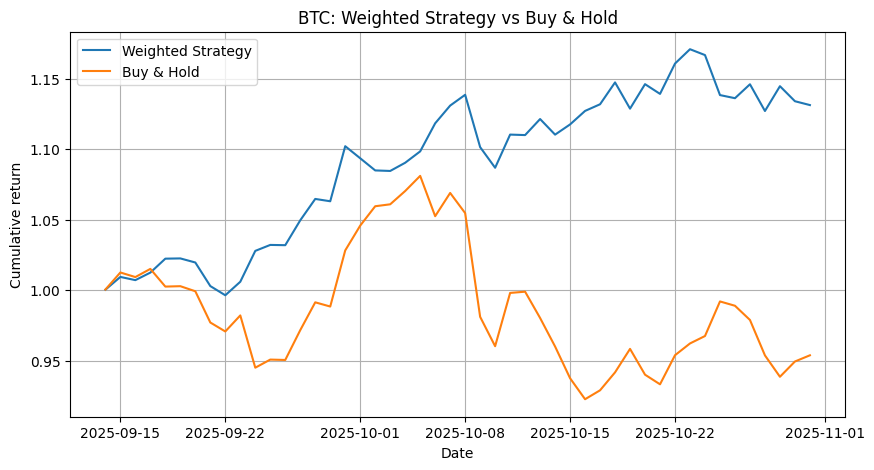

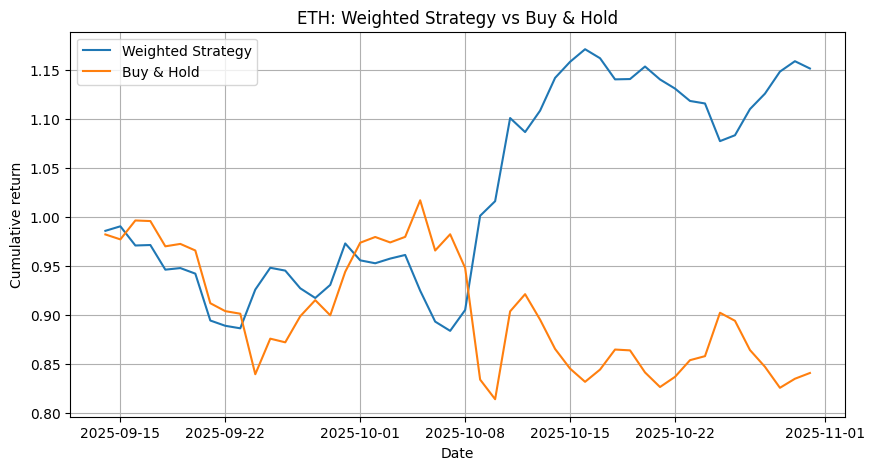

In [ ]:
import matplotlib.pyplot as plt

def plot_weighted_backtest(df, title="Weighted strategy vs Buy & Hold"):
    """
    Plot cumulative returns of the weighted strategy vs buy-and-hold.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(df["date"], df["cum_strategy_weighted"], label="Weighted Strategy")
    plt.plot(df["date"], df["cum_buyhold"], label="Buy & Hold")
    plt.legend()
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative return")
    plt.grid(True)
    plt.show()

plot_weighted_backtest(btc_weighted, title="BTC: Weighted Strategy vs Buy & Hold")
plot_weighted_backtest(eth_weighted, title="ETH: Weighted Strategy vs Buy & Hold")


## explanation

### How the ML Trading Signal Works

Each day:
- **Classifier** predicts direction → long or short  
- **Regressor** predicts volatility → position weight  
- Final position = direction × weight  
- Strategy return = position × next-day return  
- Cumulative returns form the blue line in our charts


| Date    | Predicted Direction | Predicted Volatility | Position (Dir × Weight) |
|---------|---------------------|-----------------------|---------------------------|
| Oct 28  | down (–1)           | 0.72                  | –0.72                    |
| Oct 29  | down (–1)           | 0.80                  | –0.80                    |
| Oct 30  | up (+1)             | 0.82                  | +0.82                    |


##Possible questions

###Q1. Is next-day volatility prediction considered a long-term model?

Answer:
No — this is a short-term forecasting model.
Our setup is strictly:

Today’s features → Predict tomorrow’s direction & volatility


We do not predict next week or next month.
This is a daily tactical model, not a long-term projection.

### ❓ Q2. Why use a time-based split instead of random splitting?

Answer:
Random splitting causes data leakage, because future information leaks into the training set.
Time-based splitting mimics real trading:

Train on the past → Validate on the recent → Test on the future


This preserves chronological order and avoids look-ahead bias.

### ❓ Q3. Why include a baseline model like Logistic Regression?

Answer:
To show that a simple linear model cannot capture non-linear market behavior.
When XGBoost outperforms Logistic Regression, it demonstrates:

Non-linear patterns exist

Sentiment + technical interactions matter

The advanced model meaningfully improves prediction accuracy

### ❓ Q4. What do XGB signals represent?

Answer:
They represent daily trading decisions generated by the ML models.

The XGBoost Classifier predicts direction → long or short

The XGBoost Regressor predicts volatility → position size

The trading system then combines them into:

position = direction × weight


This becomes the strategy’s daily return.

### ❓ Q5. How do you compare your strategy to Buy & Hold?

Answer:
Buy & Hold buys BTC on day 1 and holds it forever.
Our ML strategy adjusts:

Direction

Position size

Comparison uses cumulative returns:

Strategy cumulative return vs BTC cumulative return


If the ML strategy > Buy & Hold, the model generates alpha.

### ❓ Q6. Why does the weighted strategy outperform fixed long/short?

Answer:
Because it dynamically adjusts to predicted volatility:

High expected volatility → large position

Low volatility → small position

Wrong predictions have limited damage

Right predictions have amplified reward

This risk-adjusted sizing increases performance and stability.

### ❓ Q7. Can this model be applied to future data?

Answer:
Yes.
As long as we can compute today’s features (technical indicators + sentiment),
the model can output:

direction

volatility

recommended position size

Thus it can be deployed as a real-time daily signal generator.